
# :📚 Comparative Study of ANN, CNN, and ADNEI Ensemble Models on the Fashion-MNIST Dataset:








## 1. Setup & Imports

In [1]:

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
from IPython.display import display, Markdown
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# ----------------------------------------------------------
# 1️⃣ Setup
# ----------------------------------------------------------
SEED = 2025
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print("TensorFlow:", tf.__version__)

# Enable XLA JIT (can speed up many small ops by fusing them)
try:
    tf.config.optimizer.set_jit(True)
    print("XLA JIT enabled")
except Exception as e:
    print("Could not enable XLA JIT:", e)

# If you want to list GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU(s) detected: {[g.name for g in gpus]}")
else:
    print("No GPU detected — running on CPU")


TensorFlow: 2.19.0
XLA JIT enabled
GPU(s) detected: ['/physical_device:GPU:0']


## 2. Load & Prepare Data (Fashion-MNIST)

In [2]:
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

class_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
               "Sandal","Shirt","Sneaker","Bag","Ankle boot"]
NUM_CLASSES = len(class_names)

FRACTION = 0.5
n = int(len(x_train_full) * FRACTION)
x_train_full, y_train_full = x_train_full[:n], y_train_full[:n]

# Train / Val split (still using sklearn for stratify convenience)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.1, random_state=SEED, stratify=y_train_full
)

print(f"Train={x_train.shape}, Val={x_val.shape}, Test={x_test.shape}")

# One-hot for metrics and final training (we'll keep labels as ints for tf.data map and convert in model where needed)
y_test_oh = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train=(27000, 28, 28), Val=(3000, 28, 28), Test=(10000, 28, 28)


## 3. tf.data pipeline helpers

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
# Batch size tuned to GPU — try 256, 512, or larger if you have memory
BATCH_SIZE = 256 if gpus else 64

def make_dataset(x, y, batch_size=BATCH_SIZE, training=True, expand_dims=True, one_hot=False):
    # x: np array of shape (N,28,28), y: int labels or one-hot optionally
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if training:
        ds = ds.shuffle(buffer_size=10000, seed=SEED)
    def _prep(image, label):
        # ensure float32 and optionally expand dims (for conv)
        image = tf.cast(image, tf.float32)
        if expand_dims:
            image = tf.expand_dims(image, -1)  # (28,28,1)
        if one_hot:
            label = tf.one_hot(label, depth=NUM_CLASSES)
        return image, label
    ds = ds.map(_prep, num_parallel_calls=AUTOTUNE)
    # cache in memory (good for small datasets like Fashion-MNIST)
    ds = ds.cache()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTOTUNE)
    return ds


train_ds_cnn = make_dataset(x_train, y_train, batch_size=BATCH_SIZE, training=True, expand_dims=True, one_hot=True)
val_ds_cnn = make_dataset(x_val, y_val, batch_size=BATCH_SIZE, training=False, expand_dims=True, one_hot=True)
test_ds_cnn = make_dataset(x_test, y_test, batch_size=BATCH_SIZE, training=False, expand_dims=True, one_hot=False)


def make_dataset_flat(x, y, batch_size=BATCH_SIZE, training=True):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if training:
        ds = ds.shuffle(buffer_size=10000, seed=SEED)
    def _prep_flat(image, label):
        image = tf.cast(image, tf.float32)
        image = tf.reshape(image, [-1])  # flatten to (784,)
        label = tf.one_hot(label, depth=NUM_CLASSES)
        return image, label
    ds = ds.map(_prep_flat, num_parallel_calls=AUTOTUNE)
    ds = ds.cache()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds_ann = make_dataset_flat(x_train, y_train, batch_size=BATCH_SIZE, training=True)
val_ds_ann = make_dataset_flat(x_val, y_val, batch_size=BATCH_SIZE, training=False)


## 4. Dataset visualization

/tmp/ipython-input-2289220100.py:10: UserWarning: Glyph 128085 (\N{T-SHIRT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128085 (\N{T-SHIRT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


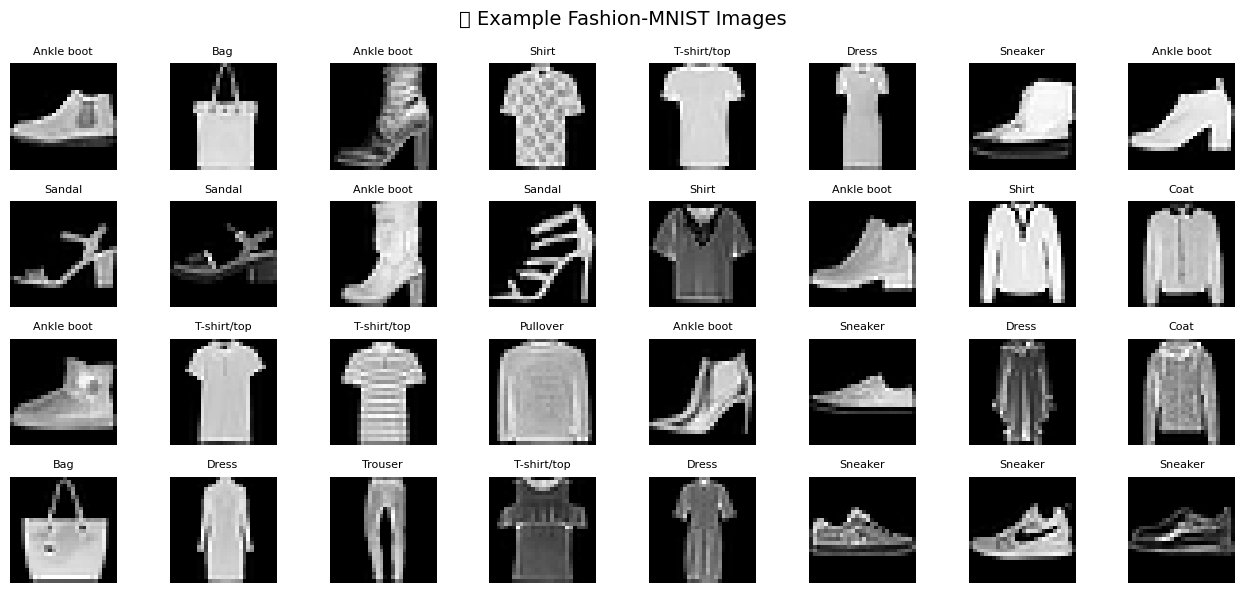

In [4]:

def show_dataset_samples_from_array(images, labels, names, n_rows=4, n_cols=8):
    plt.figure(figsize=(13,6))
    idxs = np.random.choice(range(images.shape[0]), n_rows*n_cols, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(names[labels[idx]], fontsize=8)
        plt.axis("off")
    plt.suptitle("👕 Example Fashion-MNIST Images", fontsize=14)
    plt.tight_layout()
    plt.show()

# Quick sample (optional)
show_dataset_samples_from_array(x_train, y_train, class_names)


## 5. Model definitions (ANN & CNN)

In [5]:
def create_ann():
    return models.Sequential([
        layers.Input(shape=(28*28,)),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ], name="MLP_ANN")

def create_cnn():
    return models.Sequential([
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ], name="CNN_Model")


## 6. Training configuration and callbacks

In [6]:
EPOCHS = 15
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1)
]


## 7. Train ANN and CNN

In [7]:

# Train ANN (using tf.data)

ann = create_ann()
ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("\n Training ANN...")
hist_ann = ann.fit(train_ds_ann, validation_data=val_ds_ann,
                   epochs=EPOCHS, verbose=2, callbacks=callbacks)

# Train CNN (using tf.data)

cnn = create_cnn()
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("\n Training CNN...")
hist_cnn = cnn.fit(train_ds_cnn, validation_data=val_ds_cnn,
                   epochs=EPOCHS, verbose=2, callbacks=callbacks)



 Training ANN...
Epoch 1/15
106/106 - 8s - 76ms/step - accuracy: 0.7190 - loss: 0.7736 - val_accuracy: 0.8137 - val_loss: 0.4954 - learning_rate: 1.0000e-03
Epoch 2/15
106/106 - 0s - 3ms/step - accuracy: 0.8259 - loss: 0.4822 - val_accuracy: 0.8457 - val_loss: 0.4202 - learning_rate: 1.0000e-03
Epoch 3/15
106/106 - 0s - 3ms/step - accuracy: 0.8427 - loss: 0.4312 - val_accuracy: 0.8570 - val_loss: 0.3845 - learning_rate: 1.0000e-03
Epoch 4/15
106/106 - 0s - 3ms/step - accuracy: 0.8557 - loss: 0.3967 - val_accuracy: 0.8660 - val_loss: 0.3609 - learning_rate: 1.0000e-03
Epoch 5/15
106/106 - 0s - 3ms/step - accuracy: 0.8637 - loss: 0.3718 - val_accuracy: 0.8693 - val_loss: 0.3591 - learning_rate: 1.0000e-03
Epoch 6/15
106/106 - 0s - 3ms/step - accuracy: 0.8676 - loss: 0.3583 - val_accuracy: 0.8630 - val_loss: 0.3547 - learning_rate: 1.0000e-03
Epoch 7/15
106/106 - 0s - 3ms/step - accuracy: 0.8736 - loss: 0.3443 - val_accuracy: 0.8677 - val_loss: 0.3477 - learning_rate: 1.0000e-03
Epoch 8/

## 8. Model summaries

In [8]:
print("===== ANN Model Summary =====")
display(Markdown(f"**Model: 'MLP_ANN'**"))
ann.summary()

print("===== CNN Model Summary =====")
display(Markdown(f"**Model: 'CNN_Model'**"))
cnn.summary()


===== ANN Model Summary =====


**Model: 'MLP_ANN'**

Model: "MLP_ANN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,702,304 (6.49 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,134,870 (4.33 MB)

===== CNN Model Summary =====


**Model: 'CNN_Model'**

Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,264,928 (4.83 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 843,286 (3.22 MB)

## 9. ADNEI Ensemble

In [9]:

class ADNEI:
    def __init__(self, model1, model2):
        self.model1 = model1
        self.model2 = model2

    def predict(self, x_flat, x_conv):
        y_pred_ann = self.model1.predict(x_flat, verbose=0)
        y_pred_cnn = self.model2.predict(x_conv, verbose=0)
        y_pred_adnei = (y_pred_ann + y_pred_cnn) / 2
        return y_pred_adnei

adnei = ADNEI(ann, cnn)


## 10. Evaluation helpers and plotting functions

In [10]:

def compute_metrics(y_true, y_pred):
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=range(NUM_CLASSES))
    acc_class = np.array([np.mean(y_pred[y_true==i]==i) for i in range(NUM_CLASSES)])
    return prec, rec, f1, acc_class

def plot_curves(history, title):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f"{title} Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f"{title} Accuracy"); plt.legend()
    plt.tight_layout()
    plt.show()

def show_confusion(y_true, y_pred, name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} Confusion Matrix"); plt.xlabel('Predicted'); plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def plot_metric_bars_comparison(metric_ann, metric_cnn, metric_name):
    x = np.arange(NUM_CLASSES)
    width = 0.35
    plt.figure(figsize=(13,5))
    plt.bar(x - width/2, metric_ann, width, label='ANN')
    plt.bar(x + width/2, metric_cnn, width, label='CNN')
    plt.xticks(x, class_names, rotation=45, ha='right')
    plt.ylabel(metric_name)
    plt.ylim(0, 1.05)
    plt.title(f"Class-wise {metric_name}: ANN vs CNN")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_combined_training_curves(hist_ann, hist_cnn):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(hist_ann.history['loss'], label='ANN Train')
    plt.plot(hist_ann.history['val_loss'], label='ANN Val', linestyle='--')
    plt.plot(hist_cnn.history['loss'], label='CNN Train')
    plt.plot(hist_cnn.history['val_loss'], label='CNN Val', linestyle='--')
    plt.title("Training & Validation Loss: ANN vs CNN")
    plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(hist_ann.history['accuracy'], label='ANN Train')
    plt.plot(hist_ann.history['val_accuracy'], label='ANN Val', linestyle='--')
    plt.plot(hist_cnn.history['accuracy'], label='CNN Train')
    plt.plot(hist_cnn.history['val_accuracy'], label='CNN Val', linestyle='--')
    plt.title("Training & Validation Accuracy: ANN vs CNN")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend()
    plt.tight_layout()
    plt.show()


## 11. Predictions, metrics, and visualizations

===== ANN Loss & Accuracy Curves =====


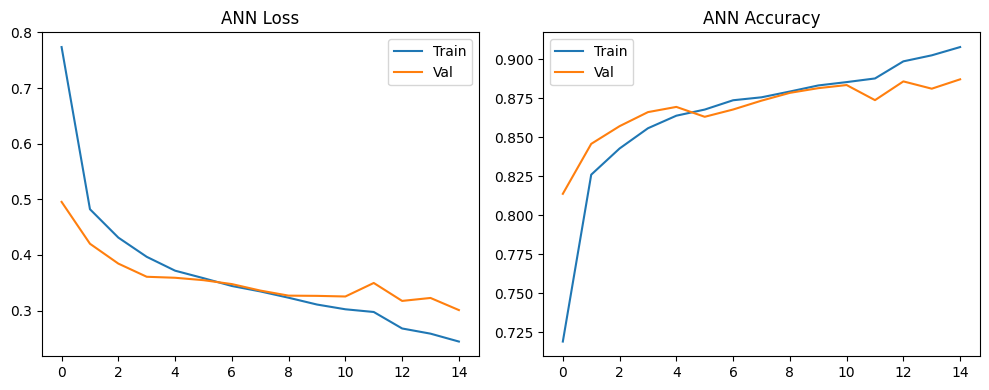

===== CNN Loss & Accuracy Curves =====


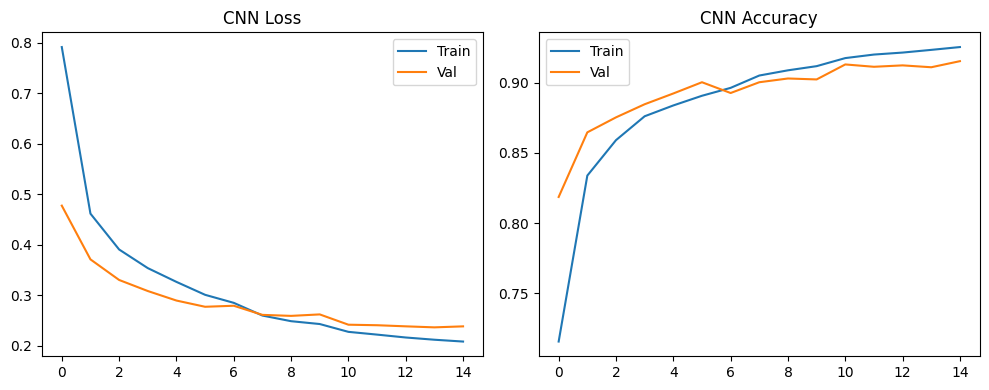

===== Combined Training Curves: ANN vs CNN =====


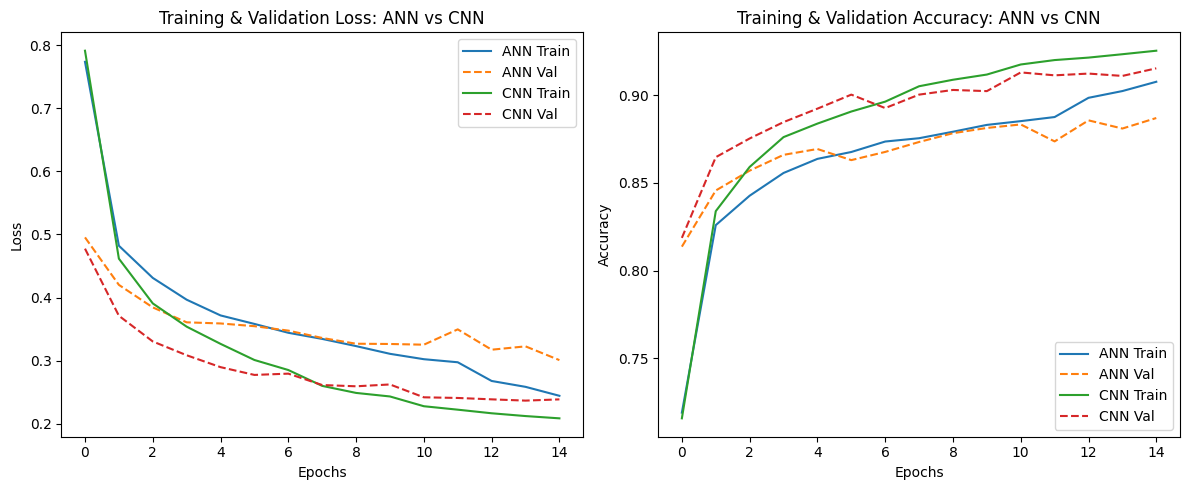

===== ANN vs CNN Metric Comparison =====


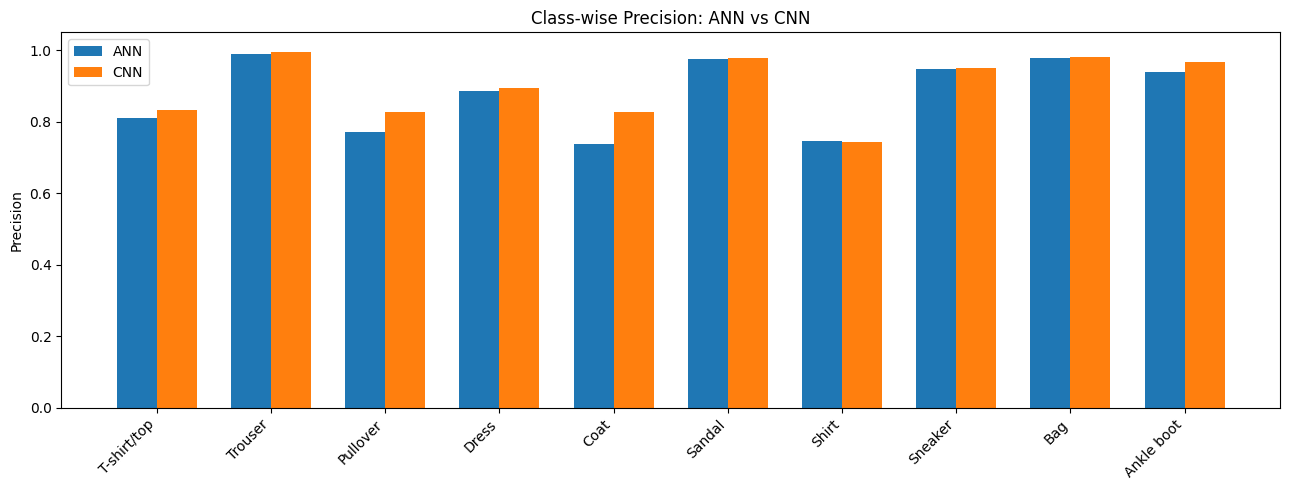

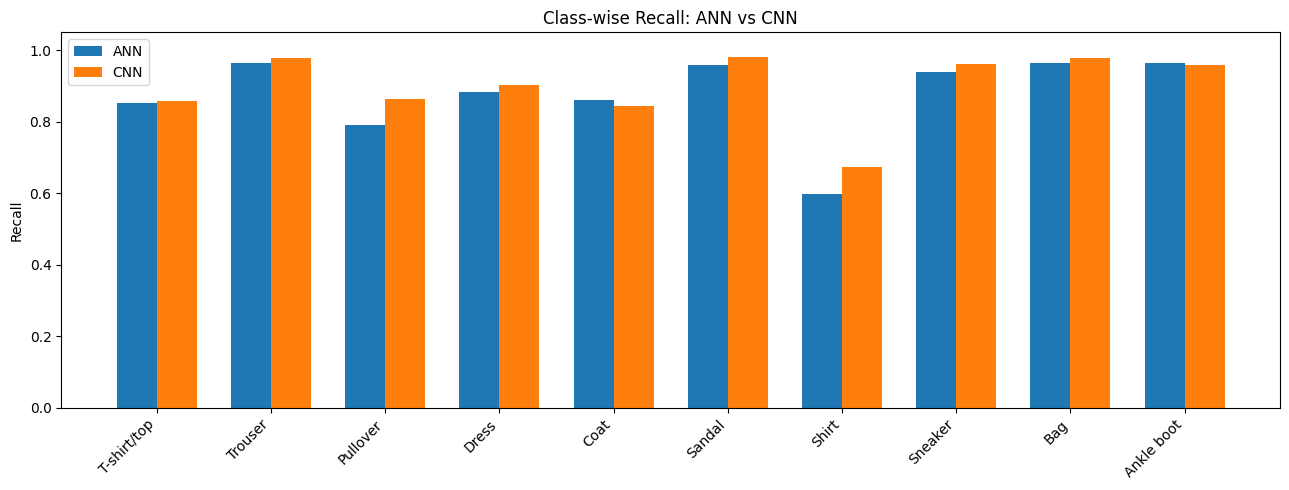

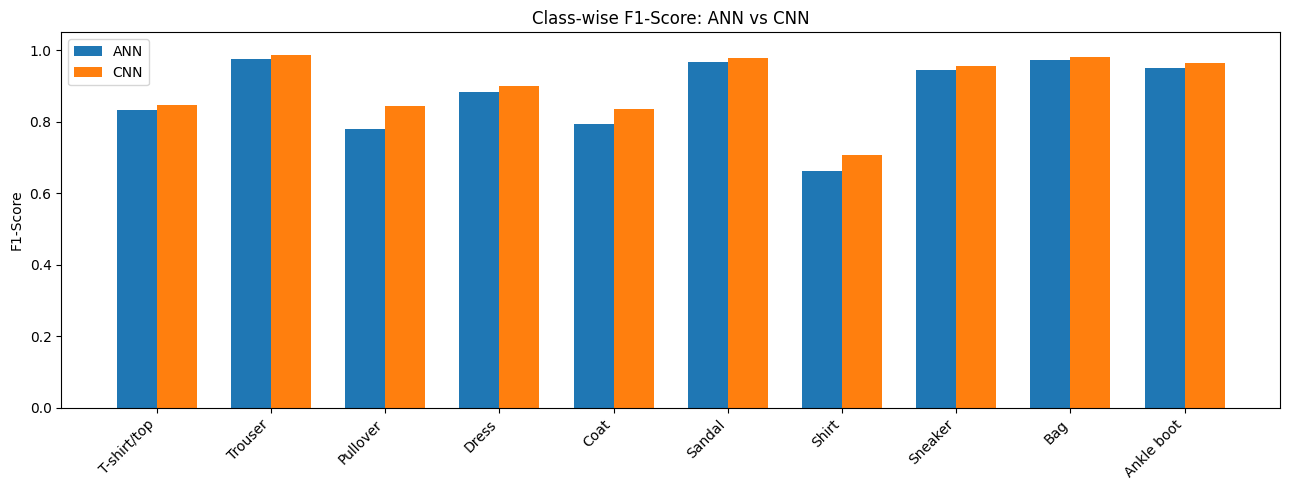

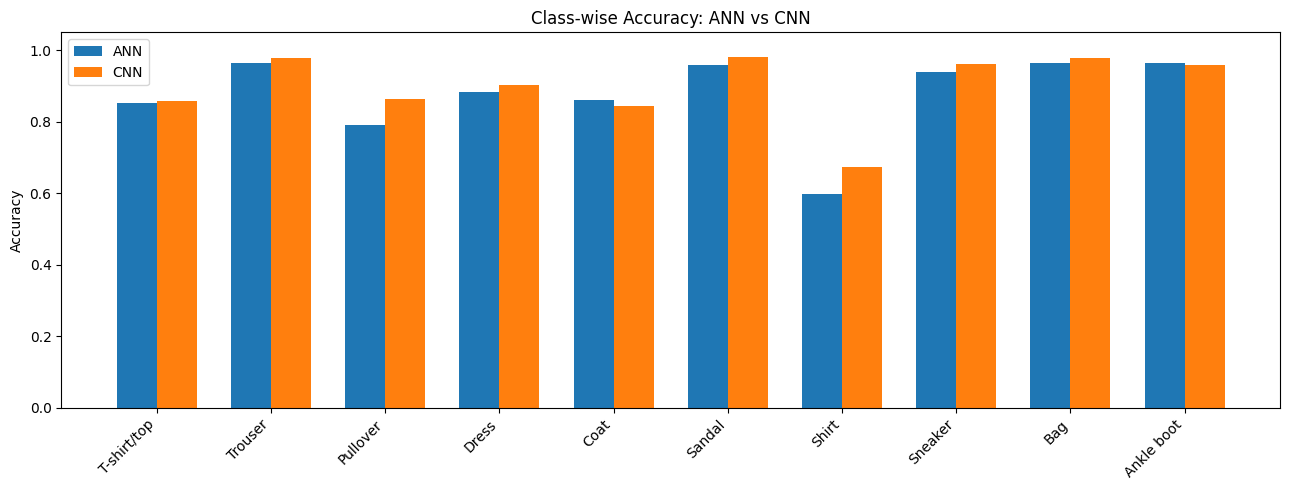

\n===== ANN Confusion Matrix =====


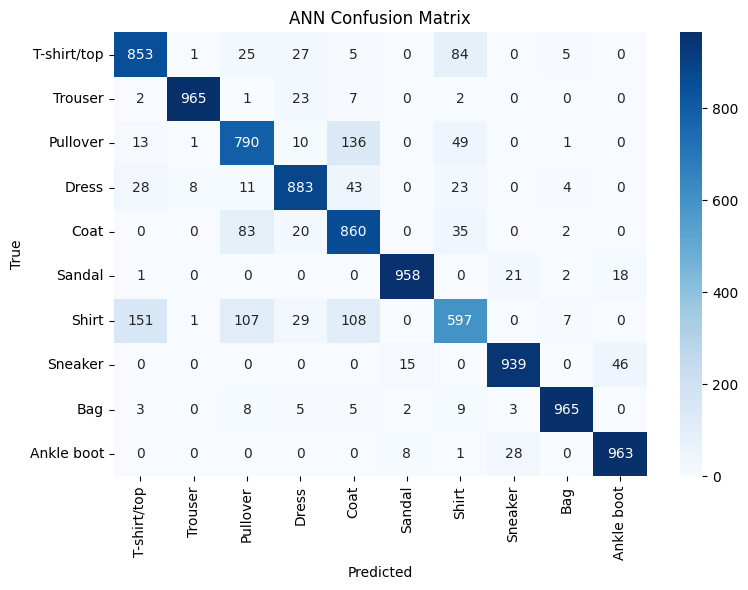

\n===== CNN Confusion Matrix =====


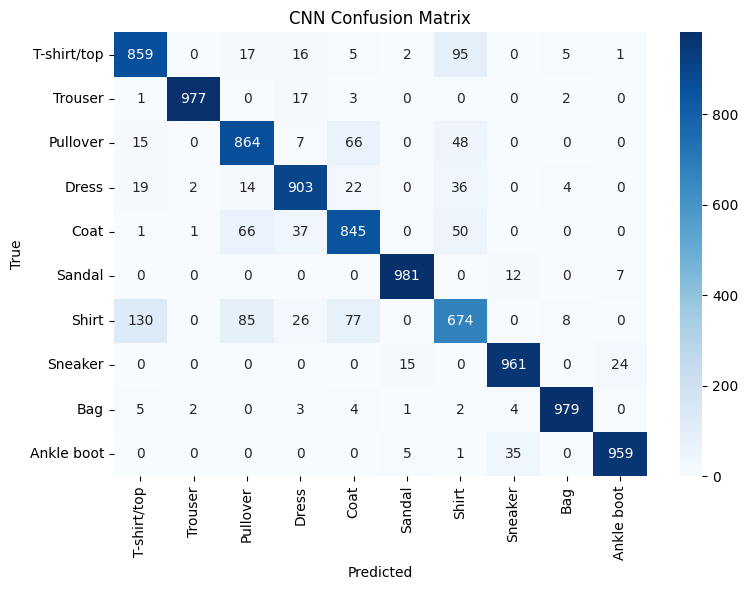

In [11]:
x_test_flat = x_test.reshape((-1, 28*28)).astype('float32')
x_test_c = np.expand_dims(x_test, -1).astype('float32')

y_pred_ann = np.argmax(ann.predict(x_test_flat, verbose=0), axis=1)
y_pred_cnn = np.argmax(cnn.predict(x_test_c, verbose=0), axis=1)
y_pred_adnei = np.argmax(adnei.predict(x_test_flat, x_test_c), axis=1)
y_true = y_test

prec_ann, rec_ann, f1_ann, acc_ann = compute_metrics(y_true, y_pred_ann)
prec_cnn, rec_cnn, f1_cnn, acc_cnn = compute_metrics(y_true, y_pred_cnn)
prec_ens, rec_ens, f1_ens, acc_ens = compute_metrics(y_true, y_pred_adnei)

#  Curves & comparisons (same plotting)

print("===== ANN Loss & Accuracy Curves =====")
plot_curves(hist_ann, "ANN")

print("===== CNN Loss & Accuracy Curves =====")
plot_curves(hist_cnn, "CNN")

print("===== Combined Training Curves: ANN vs CNN =====")
plot_combined_training_curves(hist_ann, hist_cnn)

print("===== ANN vs CNN Metric Comparison =====")
plot_metric_bars_comparison(prec_ann, prec_cnn, "Precision")
plot_metric_bars_comparison(rec_ann, rec_cnn, "Recall")
plot_metric_bars_comparison(f1_ann, f1_cnn, "F1-Score")
plot_metric_bars_comparison(acc_ann, acc_cnn, "Accuracy")

print("\\n===== ANN Confusion Matrix =====")
show_confusion(y_true, y_pred_ann, "ANN")

print("\\n===== CNN Confusion Matrix =====")
show_confusion(y_true, y_pred_cnn, "CNN")


12. ANN, CNN & Ensemble Performance Summary

In [12]:
macro_f1_ann = np.mean(f1_ann)
macro_prec_ann = np.mean(prec_ann)
macro_rec_ann = np.mean(rec_ann)

macro_f1_cnn = np.mean(f1_cnn)
macro_prec_cnn = np.mean(prec_cnn)
macro_rec_cnn = np.mean(rec_cnn)

macro_f1_ens = np.mean(f1_ens)
macro_prec_ens = np.mean(prec_ens)
macro_rec_ens = np.mean(rec_ens)

metrics_table = pd.DataFrame({
    "Model": ["ANN", "CNN", "ADNEI Ensemble"],
    "Accuracy": [np.mean(acc_ann), np.mean(acc_cnn), np.mean(acc_ens)],
    "Macro Precision": [macro_prec_ann, macro_prec_cnn, macro_prec_ens],
    "Macro Recall": [macro_rec_ann, macro_rec_cnn, macro_rec_ens],
    "Macro F1-Score": [macro_f1_ann, macro_f1_cnn, macro_f1_ens]
})

metrics_table.iloc[:,1:] = metrics_table.iloc[:,1:] * 100
metrics_table = metrics_table.round(2)

print("===== ANN, CNN & ADNEI Metrics Summary Table =====")
display(metrics_table)



===== ANN, CNN & ADNEI Metrics Summary Table =====


,Model,Accuracy,Macro Precision,Macro Recall,Macro F1-Score
0,ANN,87.73,87.80,87.73,87.63
1,CNN,90.02,89.96,90.02,89.96
2,ADNEI Ensemble,89.84,89.81,89.84,89.76


13. Simple AccuracyComparison Barplot (ANN vs CNN vs ADNEI)

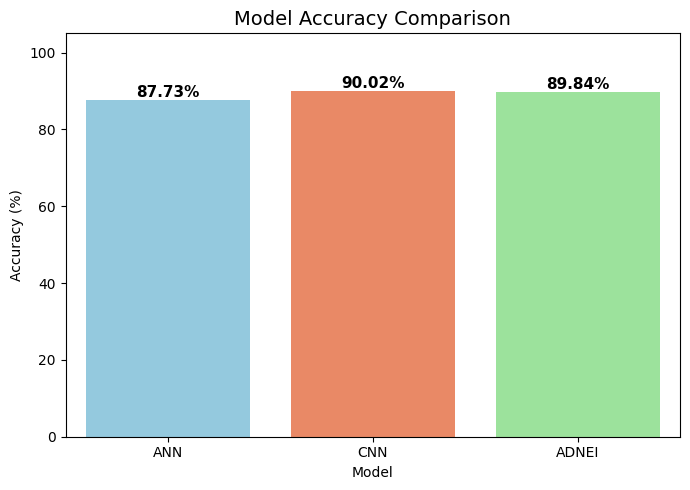

In [13]:
acc_data = pd.DataFrame({
    "Model": ["ANN", "CNN", "ADNEI"],
    "Accuracy": [
        np.mean(acc_ann) * 100,
        np.mean(acc_cnn) * 100,
        np.mean(acc_ens) * 100
    ]
})

plt.figure(figsize=(7,5))
sns.barplot(data=acc_data, x="Model", y="Accuracy", hue="Model",
            palette=["skyblue", "coral", "lightgreen"], legend=False)

for i, row in acc_data.iterrows():
    plt.text(i, row["Accuracy"] + 0.8, f"{row['Accuracy']:.2f}%",
             ha='center', fontsize=11, fontweight='bold')

plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy (%)")
plt.ylim(0, 105)
plt.tight_layout()
plt.show()


14. ADNEI Section (with Seaborn comparison)

===== ADNEI Ensemble Metrics & Visualizations =====
ADNEI Ensemble Accuracy: 89.84%


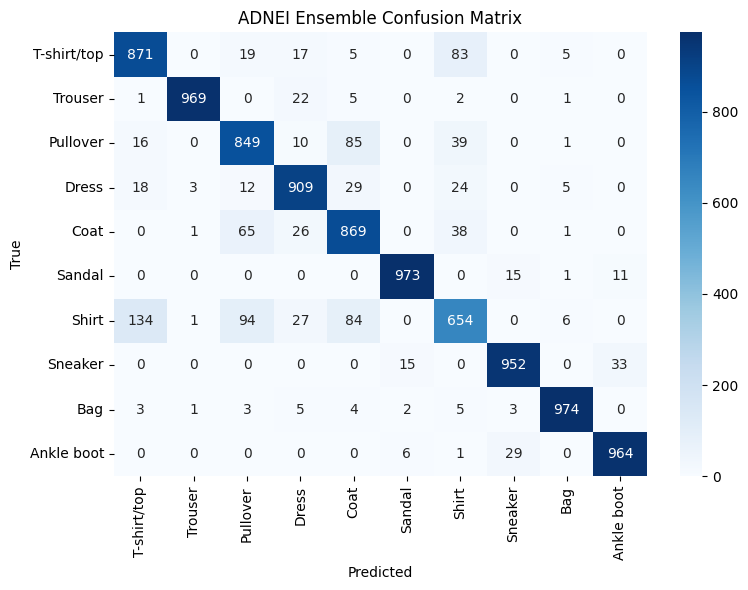

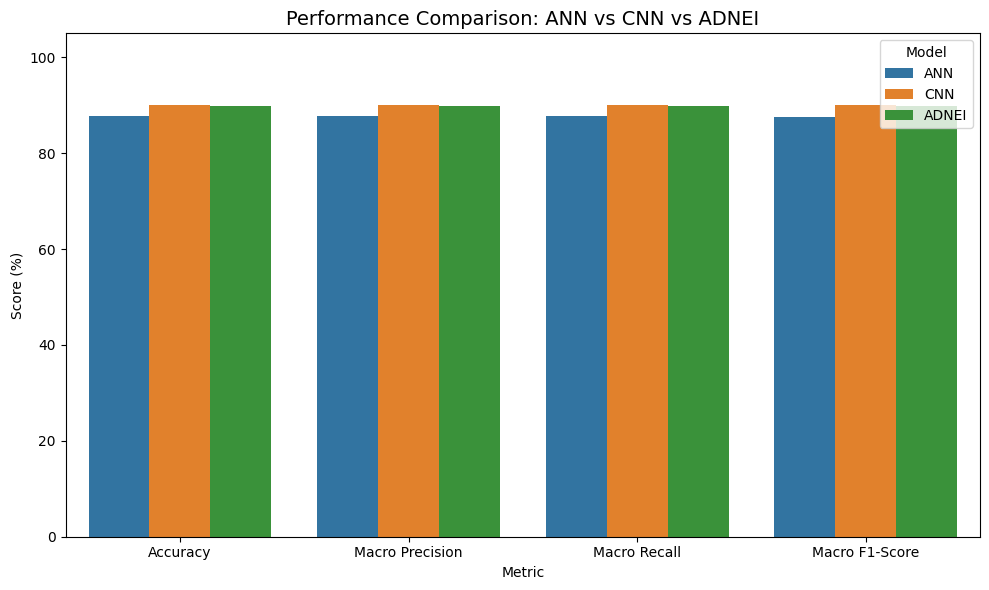

In [14]:
print("===== ADNEI Ensemble Metrics & Visualizations =====")
print(f"ADNEI Ensemble Accuracy: {np.mean(acc_ens)*100:.2f}%")

show_confusion(y_true, y_pred_adnei, "ADNEI Ensemble")

metrics = ["Accuracy", "Macro Precision", "Macro Recall", "Macro F1-Score"]
data = pd.DataFrame({
    "Metric": metrics * 3,
    "Score": [
        np.mean(acc_ann)*100, macro_prec_ann*100, macro_rec_ann*100, macro_f1_ann*100,
        np.mean(acc_cnn)*100, macro_prec_cnn*100, macro_rec_cnn*100, macro_f1_cnn*100,
        np.mean(acc_ens)*100, macro_prec_ens*100, macro_rec_ens*100, macro_f1_ens*100
    ],
    "Model": ["ANN"]*4 + ["CNN"]*4 + ["ADNEI"]*4
})

plt.figure(figsize=(10,6))
sns.barplot(x="Metric", y="Score", hue="Model", data=data)
plt.title("Performance Comparison: ANN vs CNN vs ADNEI", fontsize=14)
plt.ylabel("Score (%)")
plt.ylim(0, 105)
plt.legend(title="Model")
plt.tight_layout()
plt.show()


15. Misclassified Samples Visualization

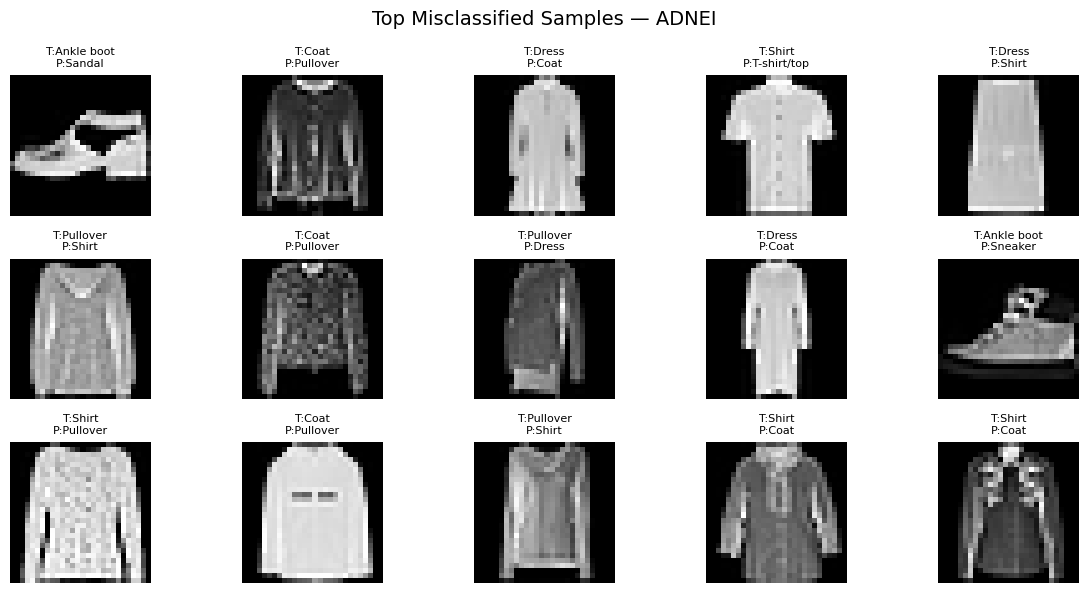

In [15]:
mis_idx = np.where(y_true != y_pred_adnei)[0]
plt.figure(figsize=(12,6))
for i, idx in enumerate(mis_idx[:15]):
    plt.subplot(3,5,i+1)
    plt.imshow(x_test[idx], cmap='gray')
    plt.title(f"T:{class_names[y_true[idx]]}\nP:{class_names[y_pred_adnei[idx]]}", fontsize=8)
    plt.axis('off')
plt.suptitle("Top Misclassified Samples — ADNEI", fontsize=14)
plt.tight_layout()
plt.show()
